In [1]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, KFold
import xgboost as xgb
import matplotlib.pyplot as plt
from modeling_utils import rmse, rmsle, eval_models, cv_sklearn_model, seed_everything


SEED = 42
CV_SPLITS = 5

seed_everything(SEED)

# Read Data

In [3]:
df = pd.read_csv('data/train.csv')
te_df = pd.read_csv('data/test.csv')
df.head()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,gender_log_mean_target,policy_l_level,vehicle_size_labeled,coverage_labeled,State : Arizona,State : California,State : Nevada,State : Oregon,State : Washington,Response : No,Response : Yes,Education : Bachelor,Education : College,Education : Doctor,Education : High School or Below,Education : Master,EmploymentStatus : Disabled,EmploymentStatus : Employed,EmploymentStatus : Medical Leave,EmploymentStatus : Retired,EmploymentStatus : Unemployed,Location Code : Rural,Location Code : Suburban,Location Code : Urban,Marital Status : Divorced,Marital Status : Married,Marital Status : Single,Policy Type : Corporate Auto,Policy Type : Personal Auto,Policy Type : Special Auto,Renew Offer Type : Offer1,Renew Offer Type : Offer2,Renew Offer Type : Offer3,Renew Offer Type : Offer4,Sales Channel : Agent,Sales Channel : Branch,Sales Channel : Call Center,Sales Channel : Web,Vehicle Class : Four-Door Car,Vehicle Class : Luxury Car,Vehicle Class : Luxury SUV,Vehicle Class : SUV,Vehicle Class : Sports Car,Vehicle Class : Two-Door Car,Customer Lifetime Value
0,0.512588,-0.792095,-1.101599,-1.184777,1.773810,-0.822662,-0.954601,-1.020428,0.891396,0.166643,-0.732294,2.088268,-0.725515,-0.32709,-0.630869,-0.309127,0.409035,-0.409035,-0.655899,-0.64447,-0.197319,1.576034,-0.297276,-0.215499,0.776207,-0.222912,-0.178567,-0.582507,2.036932,-1.311657,-0.457939,2.380090,-1.174943,-0.608173,-0.524183,0.588075,-0.20787,1.198509,-0.686821,-0.431241,-0.355514,-0.784205,-0.624762,2.042656,-0.411951,0.987205,-0.13316,-0.141848,-0.495002,-0.236397,-0.510397,2521.633095
1,0.222413,0.318522,0.189410,0.463228,-0.422244,-0.404456,0.228019,-1.020428,0.891396,0.166643,-0.732294,2.088268,-0.725515,-0.32709,-0.630869,-0.309127,-2.444513,2.444513,1.524458,-0.64447,-0.197319,-0.634435,-0.297276,-0.215499,0.776207,-0.222912,-0.178567,-0.582507,-0.490880,0.762311,-0.457939,-0.420106,-1.174943,1.644090,-0.524183,0.588075,-0.20787,1.198509,-0.686821,-0.431241,-0.355514,-0.784205,-0.624762,2.042656,-0.411951,-1.012850,-0.13316,-0.141848,2.019972,-0.236397,-0.510397,12036.620510
2,-1.240080,0.289295,1.976960,1.000621,-0.422244,-0.822662,1.066713,-1.020428,-0.419480,0.166643,-0.732294,-0.478813,-0.725515,-0.32709,1.584942,-0.309127,0.409035,-0.409035,1.524458,-0.64447,-0.197319,-0.634435,-0.297276,-0.215499,-1.288174,-0.222912,-0.178567,1.716530,-0.490880,0.762311,-0.457939,-0.420106,-1.174943,1.644090,-0.524183,0.588075,-0.20787,1.198509,-0.686821,-0.431241,-0.355514,1.275038,-0.624762,-0.489505,-0.411951,-1.012850,-0.13316,-0.141848,2.019972,-0.236397,-0.510397,3614.078436
3,0.503173,0.552337,-0.108515,1.573840,-0.422244,-0.822662,-0.027245,0.979874,-0.419480,0.166643,-0.732294,-0.478813,-0.725515,-0.32709,-0.630869,3.234567,0.409035,-0.409035,-0.655899,-0.64447,5.067393,-0.634435,-0.297276,-0.215499,0.776207,-0.222912,-0.178567,-0.582507,-0.490880,-1.311657,2.183459,-0.420106,0.851012,-0.608173,-0.524183,0.588075,-0.20787,1.198509,-0.686821,-0.431241,-0.355514,-0.784205,1.600434,-0.489505,-0.411951,-1.012850,-0.13316,-0.141848,-0.495002,4.229702,-0.510397,4530.385427
4,2.047600,0.756924,-0.803674,-0.217470,-0.422244,-0.822662,-0.434772,-1.020428,-0.419480,0.166643,-0.732294,-0.478813,1.378180,-0.32709,-0.630869,-0.309127,0.409035,-0.409035,-0.655899,-0.64447,-0.197319,1.576034,-0.297276,-0.215499,0.776207,-0.222912,-0.178567,-0.582507,-0.490880,-1.311657,2.183459,-0.420106,0.851012,-0.608173,1.907523,-1.700277,-0.20787,-0.834278,1.455825,-0.431241,-0.355514,-0.784205,-0.624762,2.042656,-0.411951,-1.012850,-0.13316,-0.141848,-0.495002,4.229702,-0.510397,4807.846463


In [4]:
# use np.log for training
y = np.log(df.pop('Customer Lifetime Value').values)
# holdout y for final validation. We will validate on original values
y_te = te_df.pop('Customer Lifetime Value').values

# Linear Regression

### Linear Regression by single features

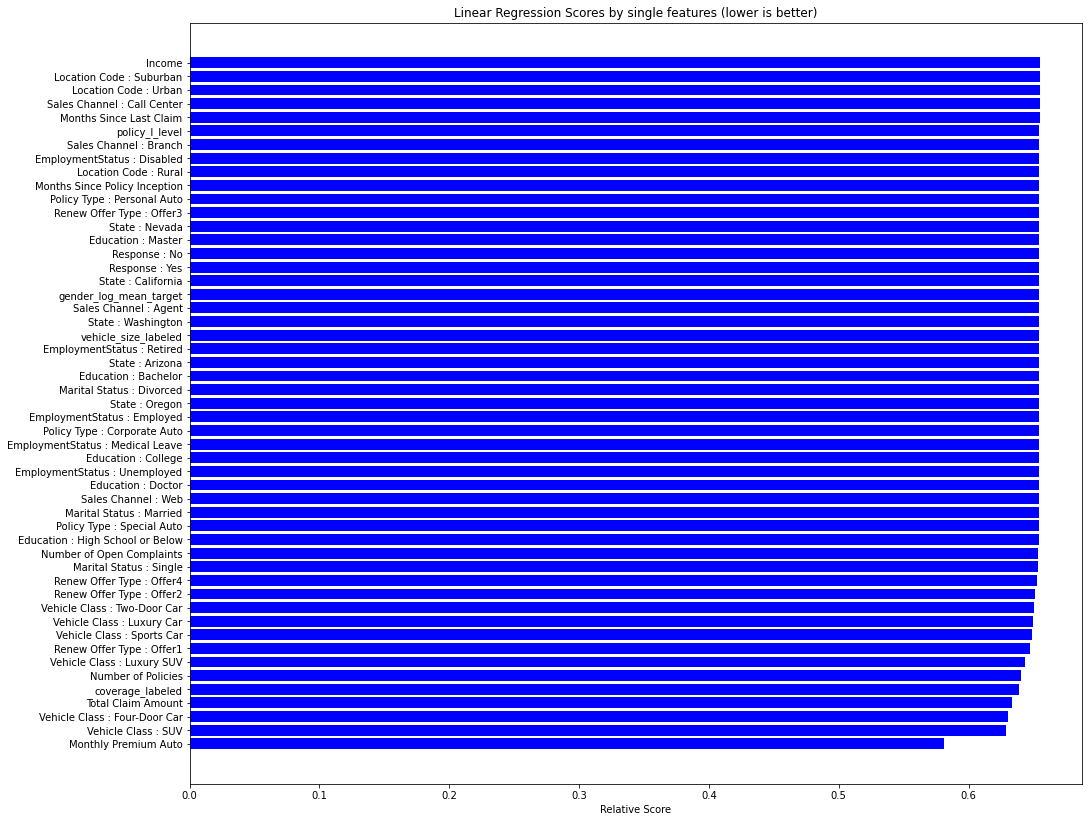

In [ ]:
linreg_single_scores = []

for col in df.columns:
    model = LinearRegression()
    model.fit(df[col].values.reshape(-1, 1), y)

    y_pred = model.predict(te_df[col].values.reshape(-1, 1))
    score = rmsle(y_te, np.exp(y_pred))
    linreg_single_scores.append(score)

    
importances = np.array(linreg_single_scores)
features = df.columns
indices = np.argsort(importances)

plt.figure(figsize=[16, 14])
plt.title('Linear Regression Scores by single features (lower is better)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Score')
plt.show()

Видно, как отдельные признаки влияют на таргет в **линейной регрессии**. Самый лучший счёт у `Monthly Premium Auto` - признака с наибольшей корреляцией

### Linear Regression by all features

In [ ]:
model = LinearRegression()
model.fit(df, y)

y_pred = model.predict(te_df)
score = rmsle(y_te, np.exp(y_pred))

print(f'LinReg RMSLE: {score}')

LinReg RMSLE: 0.5566771011371288


Если построить **линейную регрессию** на всех признаках, то счёт становится чуть лучше, но всё равно достаточно плох

# Random Forest

### RF Hyperparameters search

In [15]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start=100, stop=211, num=10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(7, 30, num=3)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {
#     'n_estimators': n_estimators,
#     'max_features': max_features,
#     'max_depth': max_depth,
#     'min_samples_split': min_samples_split,
#     'min_samples_leaf': min_samples_leaf,
#     'bootstrap': bootstrap
#               }


# rf = RandomForestRegressor()
# rf_random = RandomizedSearchCV(estimator=rf, 
#                              param_distributions=random_grid, 
#                              n_iter=100, 
#                              cv=5, 
#                              verbose=1, 
#                              random_state=SEED, 
#                              n_jobs=-1)

# rf_random.fit(df, y)
# print(rf_random.best_params_)

### RF fit & evaluate

RF RMSE score on fold 0 : 0.12196228439861673
RF RMSE score on fold 1 : 0.12020070350931084
RF RMSE score on fold 2 : 0.11865804615829131
RF RMSE score on fold 3 : 0.12135305264592515
RF RMSE score on fold 4 : 0.12096020281903376
RF CV RMSE score on 5 folds : 0.12062685790623555


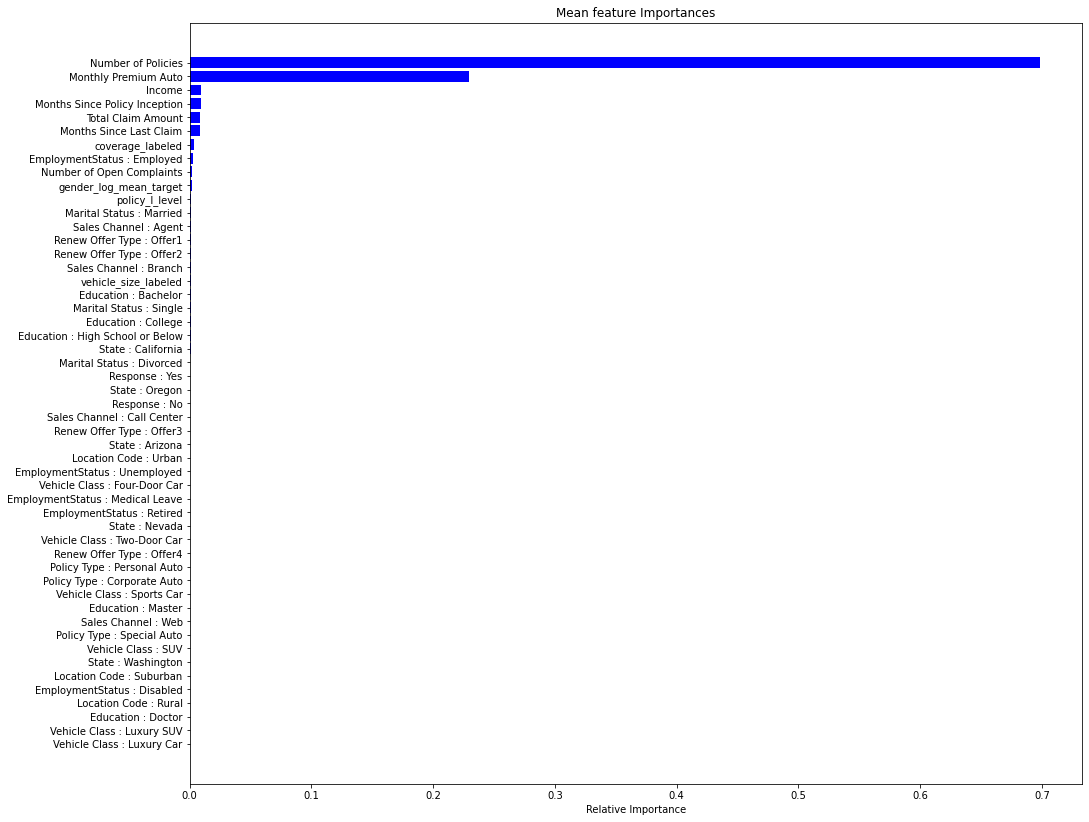

In [ ]:
folds = KFold(n_splits=CV_SPLITS, random_state=SEED, shuffle=True)

# parameters from rf_random.best_params_
params = {
    'n_estimators': 161,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
    'max_features': 'auto',
    'max_depth': None,
    'bootstrap': True,
    'random_state': SEED
         }


rf_models = cv_sklearn_model(folds=folds, 
                             df=df, 
                             y=y, 
                             eval_metric=rmse, 
                             model_class=RandomForestRegressor, 
                             params=params,
                             metric_name='RMSE', 
                             model_name='RF', 
                             plot_importances=True)

**Случайный лес** занулил важность почти всех признаков, посчитав наиболее важным `Number of Policies`. На втором месте располагается `Monthly Premium Auto`, но его важность уже в ~3 раза меньше

In [ ]:
eval_models(models=rf_models,
            X=te_df, y=np.log(y_te),
            eval_metric=rmse,
            metric_name='RMSE',
            model_name='RF')

Model RF RMSE score : 0.19356588914565598
Model RF RMSE score : 0.19539640728772542
Model RF RMSE score : 0.19390598650935917
Model RF RMSE score : 0.19428965003676982
Model RF RMSE score : 0.19177919958737052
Models RF mean RMSE score : 0.19378742651337616


In [ ]:
rf_params = {
         'n_estimators': 161,
         'min_samples_split': 2,
         'min_samples_leaf': 4,
         'max_features': 'auto',
         'max_depth': None,
         'bootstrap': True,
         'random_state': SEED
         }

rf = RandomForestRegressor(**rf_params)

rf.fit(df, y)

y_pred = rf.predict(te_df)
score = rmsle(y_te, np.exp(y_pred))

print(f'Single RF RMSLE: {score}')

Single RF RMSLE: 0.19145754698675602


Один **случайный лес**, обученный на всём тренировочном сете без CV, даёт лучший скор на отложенной выборке, нежели блендинг нескольких моделей с CV

# XGB

### XGB Hyperparameters search

In [14]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start=150, stop=1000, num=100)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [7, 9, 11, 13]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {
#     'tree_method': ['hist'],
#     'learning_rate': [0.05, 0.01002], 
#     'alpha': [0.01, 0.05],
#     'gamma': [0.2, 0.1, 0.05], 
#     'subsample': [0.95],
#     'eval_metric': ['rmse'],
#     'seed': [SEED],
#     'max_depth': [8, 12], 
#     'n_estimators': [800, 1200],
#     'scale_pos_weight': [1]
#               }


# xgbreg = xgb.XGBRegressor()
# xgbreg_random = RandomizedSearchCV(estimator=xgbreg, 
#                              param_distributions=random_grid, 
#                              n_iter=10, 
#                              cv=3, 
#                              verbose=1, 
#                              random_state=SEED, 
#                              n_jobs=-1)

# xgbreg_random.fit(df, y)
# print(xgbreg_random.best_params_)

### XGB fit & evaluate

[10:19:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor RMSE score on fold 0 : 0.10320937212453765
[10:19:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor RMSE score on fold 1 : 0.1017074560328681
[10:20:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor RMSE score on fold 2 : 0.09999592901667814
[10:20:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor RMSE score on fold 3 : 0.10236012304286664
[10:20:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor RMSE score on fold 4 : 0.10189063291167547
XGBRegressor CV RMSE score on 5 folds : 0.1018327026257252


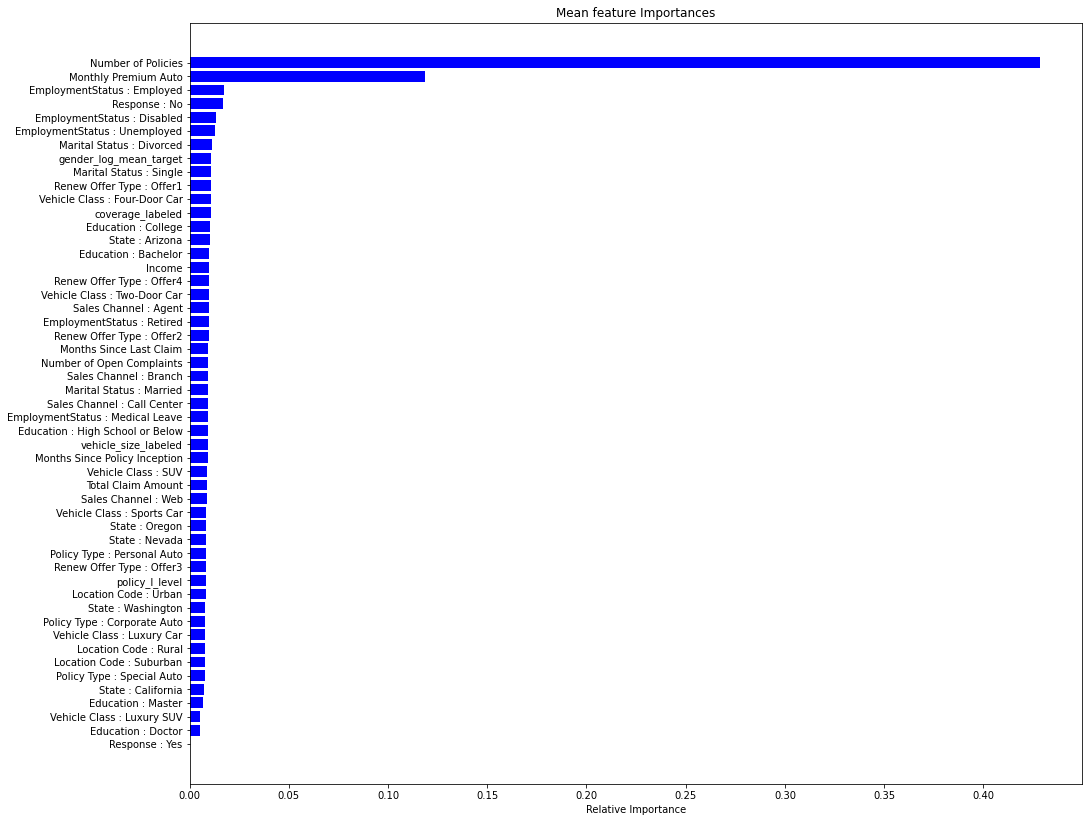

In [23]:
folds = KFold(n_splits=CV_SPLITS, random_state=SEED, shuffle=True)

# parameters from xgbreg_random.best_params_
xgb_params = {
    'tree_method': 'hist',
    'subsample': 0.95,
    'seed': 42,
    'scale_pos_weight': 1,
    'n_estimators': 1200,
    'max_depth': 8,
    'learning_rate': 0.01002,
    'gamma': 0.1,
    'eval_metric': 'rmse',
    'alpha': 0.05
}

xgb_models = cv_sklearn_model(folds=folds, 
                              df=df, 
                              y=y, 
                              eval_metric=rmse, 
                              model_class=xgb.XGBRegressor, 
                              params=xgb_params,
                              metric_name='RMSE', 
                              model_name='XGBRegressor', 
                              plot_importances=True)

**XGBoost** не занулил важность большинства признаков, но сделал её достаточно маленькой. По выбору 2 наиболее важных признаков результат похож на выбор **случайного леса**, а именно `Number of Policies` и `Monthly Premium Auto` имеют максимальную важность, при этом у `Number of Policies` она в несколько раз больше

In [28]:
eval_models(models=xgb_models,
            X=te_df.values, y=np.log(y_te),
            eval_metric=rmse,
            metric_name='RMSE',
            model_name='XGBRegressor')

Model XGBRegressor RMSE score : 0.19562322386168
Model XGBRegressor RMSE score : 0.1968590450158894
Model XGBRegressor RMSE score : 0.1950863558659906
Model XGBRegressor RMSE score : 0.19607482230500087
Model XGBRegressor RMSE score : 0.1926932745651749
Models XGBRegressor mean RMSE score : 0.19526734432274717


Что в ансамбле, что на отдельных фолдах **XGBoost** показывает неплохой результат, но хуже, чем у **случайного леса**, к тому же проигрывает по скорости

# Neural Network

In [7]:
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.layers import BatchNormalization,Add,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
import shap

# # load JS visualization code to notebook
shap.initjs()

In [8]:
def create_nn_model(input_shape):
    inp = Input(shape=(input_shape,))
    x = Dense(2048, activation='relu')(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    out = Dense(1, activation='linear')(x)  
    model = Model(inputs=inp, outputs=[out])
    return model

def plot_history(history, label):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss for %s' % label)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

def keras_rmse(y_true, y_pred):
    return K.sqrt(K.mean((y_true - y_pred)**2))

fold 0

Epoch 00218: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00260: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch.
Epoch 00280: early stopping


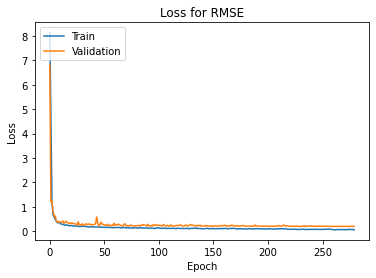

fold 1

Epoch 00155: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00191: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00229: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00305: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch.
Epoch 00325: early stopping


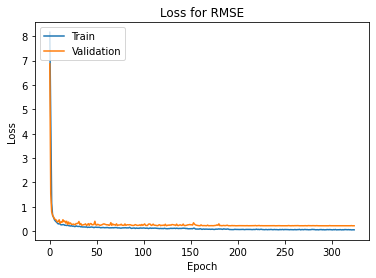

fold 2

Epoch 00108: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00146: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00189: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch.
Epoch 00209: early stopping


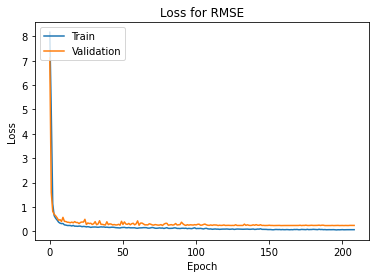

fold 3

Epoch 00135: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00207: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00241: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch.
Epoch 00261: early stopping


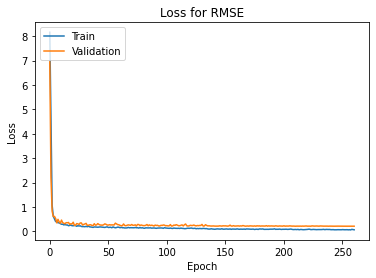

fold 4

Epoch 00128: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00172: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00213: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00262: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00307: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch.
Epoch 00327: early stopping


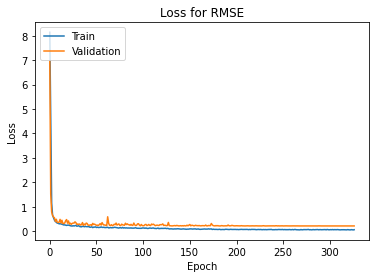

Mean score on 5 folds: 0.21464182824937703


----------------------


In [11]:
epoch_n = 2000
verbose = False
batch_size = 128


oof = np.zeros(len(y))

n_folds = 5
folds = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df, y)):
    strLog = f'fold {fold_}'
    model_name_wrt = f'cltv_fold{fold_}.hdf5'
    print(strLog)

    x_tr, x_val = df.iloc[trn_idx], df.iloc[val_idx]
    y_tr, y_val = y[trn_idx], y[val_idx]

    model = create_nn_model(x_tr.shape[1])

    model.compile(loss=keras_rmse, optimizer=Adam(), metrics=[keras_rmse])

    # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
    es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=1, mode='auto', restore_best_weights=True)
    # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
    rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, min_lr=1e-6, mode='auto', verbose=1)
    # Save the best value of the model for future use
    sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True, period=1)

    history = model.fit(x_tr, [y_tr], 
        validation_data=(x_val, [y_val]), 
        callbacks=[es, rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)

    plot_history(history, 'RMSE')

    preds = model.predict(x_val).squeeze()
    oof[val_idx] += preds


print(f'Mean score on {n_folds} folds:', rmse(y, oof))
print('')

print('')
print('----------------------')

In [31]:
nn_score = 0.0

for i in range(5):
    model.load_weights(f'cltv_fold{i}.hdf5')
    y_pred = model.predict(te_df).squeeze()

    score = rmsle(y_te, np.exp(y_pred))
    nn_score += score / 5
    print(f'NN fold{i} RMSLE score : {score}')

print(f'NN mean RMSLE score : {nn_score}')

NN fold0 RMSLE score : 0.21998787320764865
NN fold1 RMSLE score : 0.21372969810674736
NN fold2 RMSLE score : 0.2163113549980725
NN fold3 RMSLE score : 0.21924096192757928
NN fold4 RMSLE score : 0.2187249704276421
NN mean RMSLE score : 0.21759897173353798


Результат **нейронной сети** на отложенной выборке не сильно отличается от результатов на валидации

### SHAP Importances

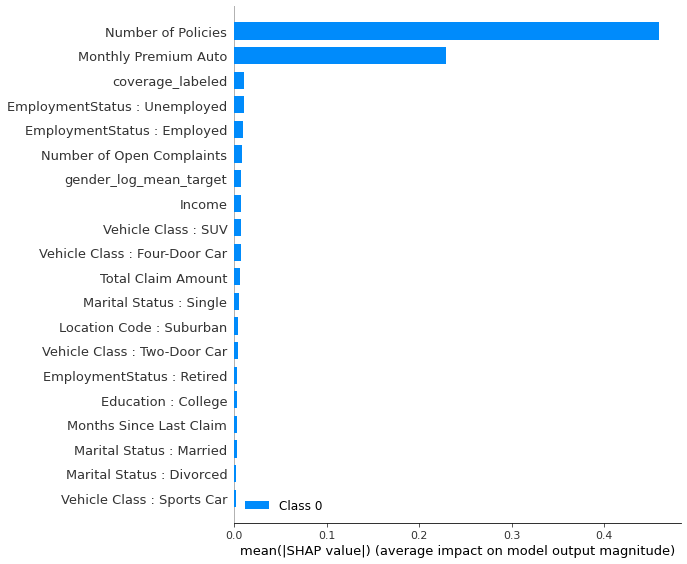

In [12]:
# explain the model's predictions using SHAP
explainer = shap.KernelExplainer(model, shap.sample(x_val, 100))
shap_values = explainer.shap_values(x_val)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0], x_val)

shap.summary_plot(shap_values, x_val, plot_type='bar')

**Нейронная сеть** имеет важность признаков похожую на важность признаков у **XGBoost**. И снова `Number of Policies` и `Monthly Premium Auto` имеют максимальную важность